## PINNs: Oscillator analysis

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sciml-book/sciml_notebook/blob/main/pinns/00-oscillator.ipynb)

Exact Solution Lipschitz Constant: 17.2519

=== Network Size: 8 ===

--- Training Standard Neural Network ---


Training Standard NN: 100%|██████████| 1000/1000 [00:00<00:00, 2209.63it/s]



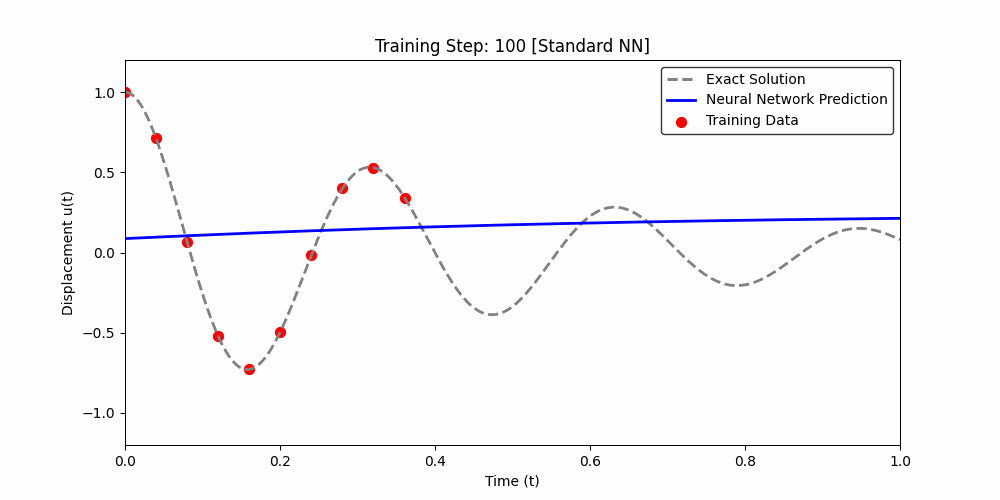


--- Training Physics-Informed Neural Network (PINN) ---


Training PINN: 100%|██████████| 20000/20000 [00:12<00:00, 1568.21it/s]



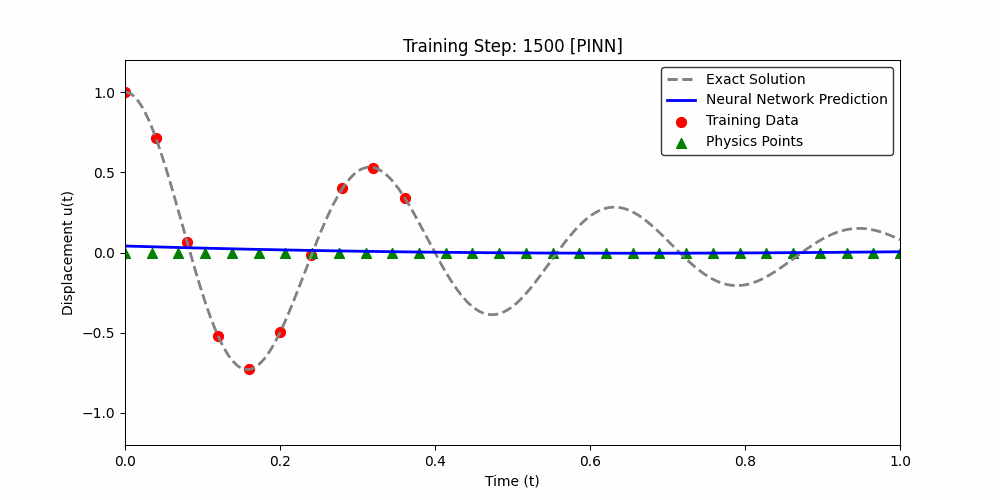


--- Performing PCA on Parameter Trajectories ---
Standard NN:
PINN:

--- Evaluating Loss Landscape for Standard NN ---


Evaluating Loss Landscape [Standard NN]: 100%|██████████| 50/50 [00:00<00:00, 143.36it/s]



--- Evaluating Loss Landscape for PINN ---


Evaluating Loss Landscape [PINN]: 100%|██████████| 50/50 [00:00<00:00, 73.44it/s]



--- Evaluating Lipschitz Constants ---
Standard NN Lipschitz Constant: 4.6182
PINN Lipschitz Constant: 14.7301

=== Network Size: 16 ===

--- Training Standard Neural Network ---


Training Standard NN: 100%|██████████| 1000/1000 [00:00<00:00, 1786.30it/s]



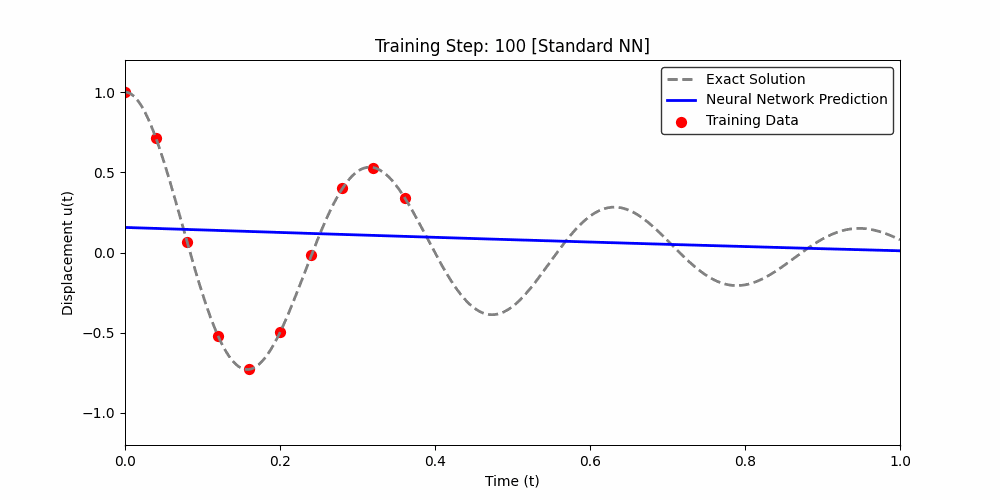


--- Training Physics-Informed Neural Network (PINN) ---


Training PINN: 100%|██████████| 20000/20000 [00:14<00:00, 1390.96it/s]



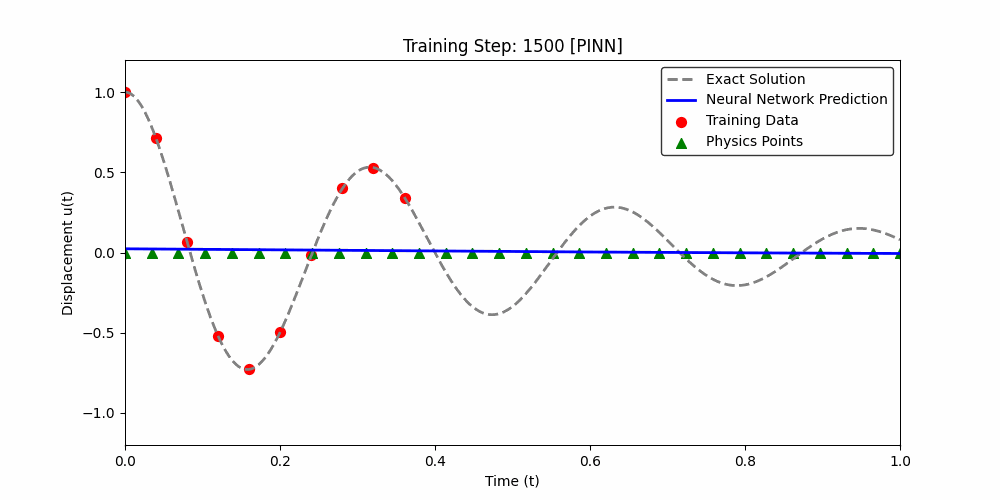


--- Performing PCA on Parameter Trajectories ---
Standard NN:
PINN:

--- Evaluating Loss Landscape for Standard NN ---


Evaluating Loss Landscape [Standard NN]: 100%|██████████| 50/50 [00:00<00:00, 147.28it/s]



--- Evaluating Loss Landscape for PINN ---


Evaluating Loss Landscape [PINN]: 100%|██████████| 50/50 [00:00<00:00, 67.10it/s]



--- Evaluating Lipschitz Constants ---
Standard NN Lipschitz Constant: 17.2926
PINN Lipschitz Constant: 17.0874

=== Network Size: 32 ===

--- Training Standard Neural Network ---


Training Standard NN: 100%|██████████| 1000/1000 [00:00<00:00, 2134.97it/s]



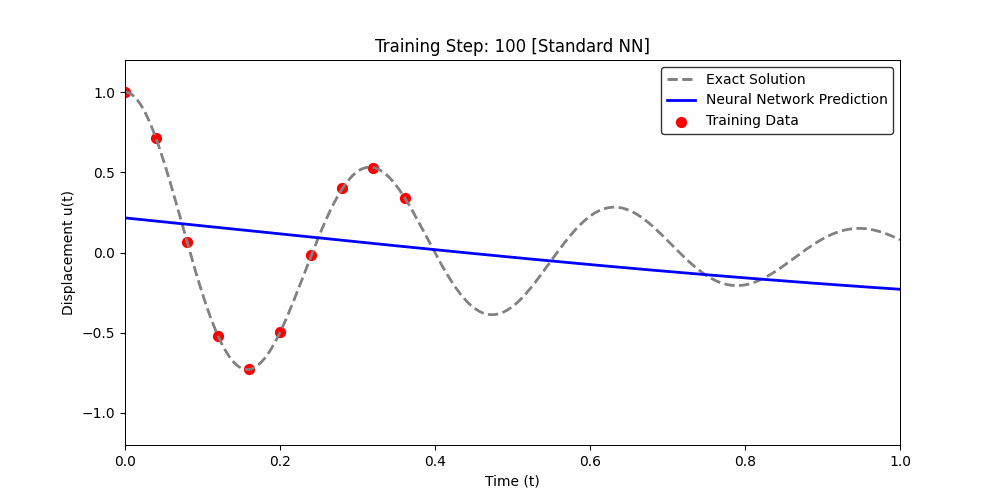


--- Training Physics-Informed Neural Network (PINN) ---


Training PINN: 100%|██████████| 20000/20000 [00:14<00:00, 1367.99it/s]



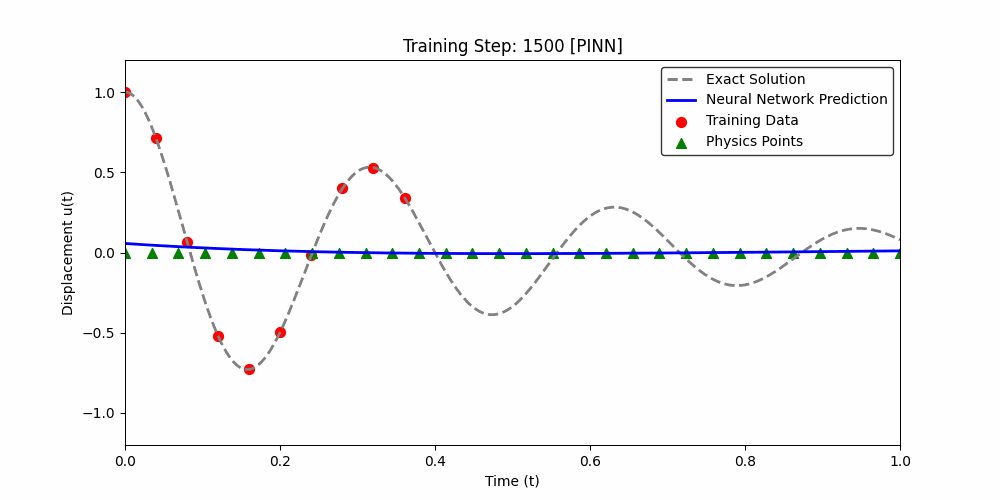


--- Performing PCA on Parameter Trajectories ---
Standard NN:
PINN:

--- Evaluating Loss Landscape for Standard NN ---


Evaluating Loss Landscape [Standard NN]: 100%|██████████| 50/50 [00:00<00:00, 149.93it/s]



--- Evaluating Loss Landscape for PINN ---


Evaluating Loss Landscape [PINN]: 100%|██████████| 50/50 [00:00<00:00, 63.85it/s]



--- Evaluating Lipschitz Constants ---
Standard NN Lipschitz Constant: 16.6128
PINN Lipschitz Constant: 17.0423

=== Network Size: 64 ===

--- Training Standard Neural Network ---


Training Standard NN: 100%|██████████| 1000/1000 [00:00<00:00, 1848.83it/s]



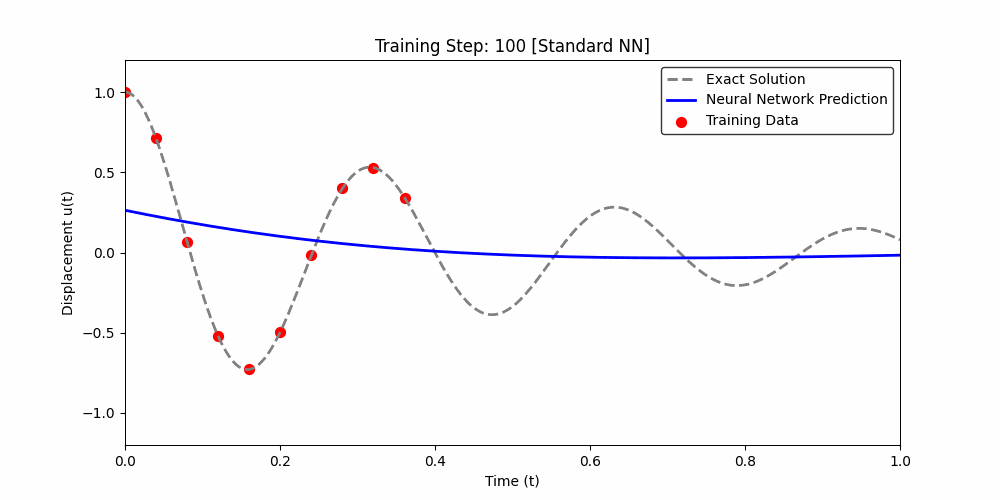


--- Training Physics-Informed Neural Network (PINN) ---


Training PINN: 100%|██████████| 20000/20000 [00:16<00:00, 1224.49it/s]



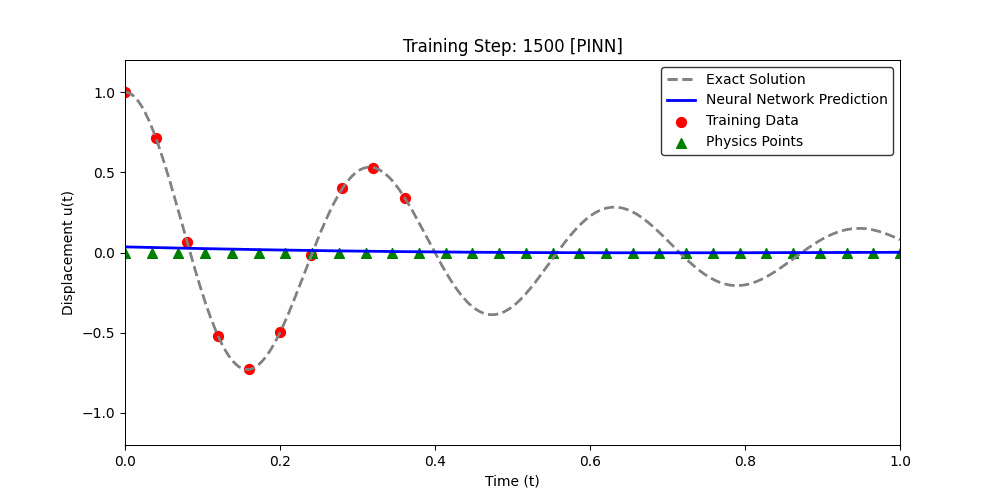


--- Performing PCA on Parameter Trajectories ---
Standard NN:
PINN:

--- Evaluating Loss Landscape for Standard NN ---


Evaluating Loss Landscape [Standard NN]: 100%|██████████| 50/50 [00:00<00:00, 132.33it/s]



--- Evaluating Loss Landscape for PINN ---


Evaluating Loss Landscape [PINN]: 100%|██████████| 50/50 [00:00<00:00, 56.79it/s]



--- Evaluating Lipschitz Constants ---
Standard NN Lipschitz Constant: 17.9082
PINN Lipschitz Constant: 17.1785

=== Network Size: 128 ===

--- Training Standard Neural Network ---


Training Standard NN: 100%|██████████| 1000/1000 [00:00<00:00, 1652.65it/s]



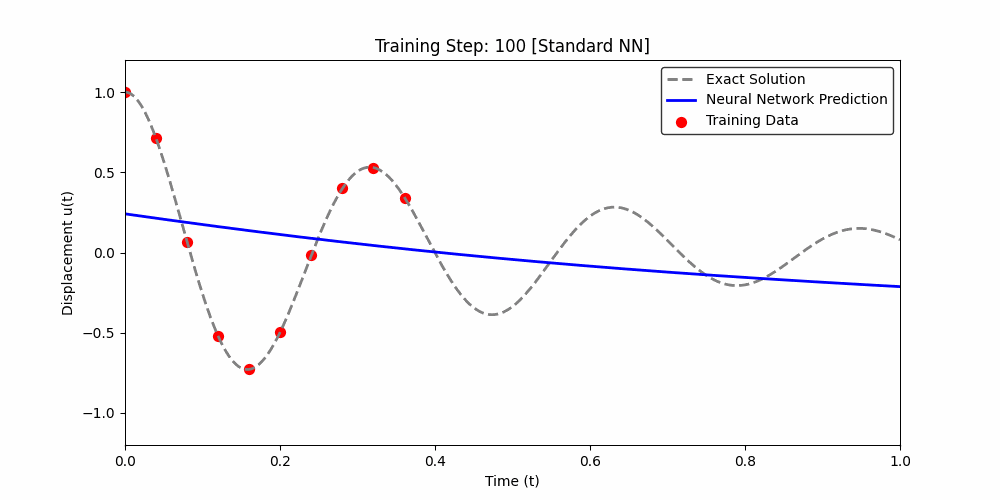


--- Training Physics-Informed Neural Network (PINN) ---


Training PINN: 100%|██████████| 20000/20000 [00:19<00:00, 1014.25it/s]



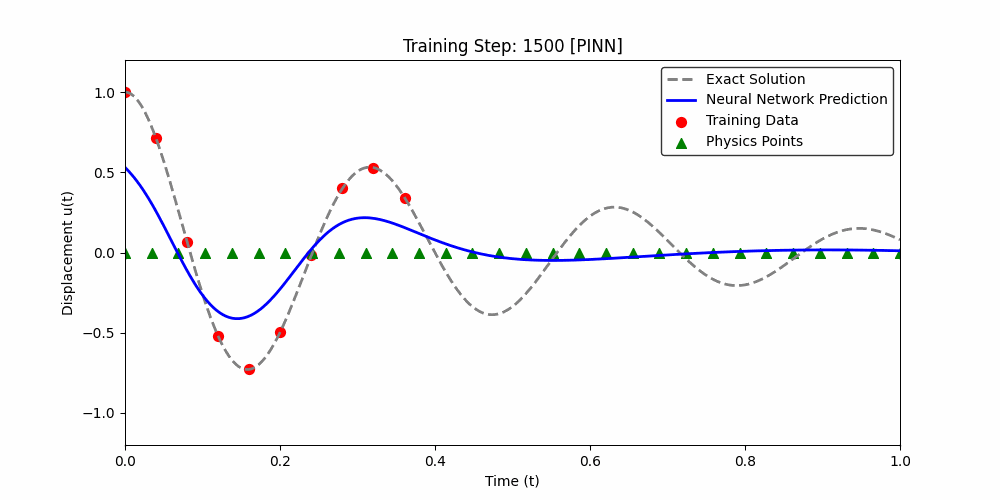


--- Performing PCA on Parameter Trajectories ---
Standard NN:
PINN:

--- Evaluating Loss Landscape for Standard NN ---


Evaluating Loss Landscape [Standard NN]: 100%|██████████| 50/50 [00:00<00:00, 112.55it/s]



--- Evaluating Loss Landscape for PINN ---


Evaluating Loss Landscape [PINN]: 100%|██████████| 50/50 [00:01<00:00, 44.86it/s]



--- Evaluating Lipschitz Constants ---
Standard NN Lipschitz Constant: 17.9274
PINN Lipschitz Constant: 17.1951


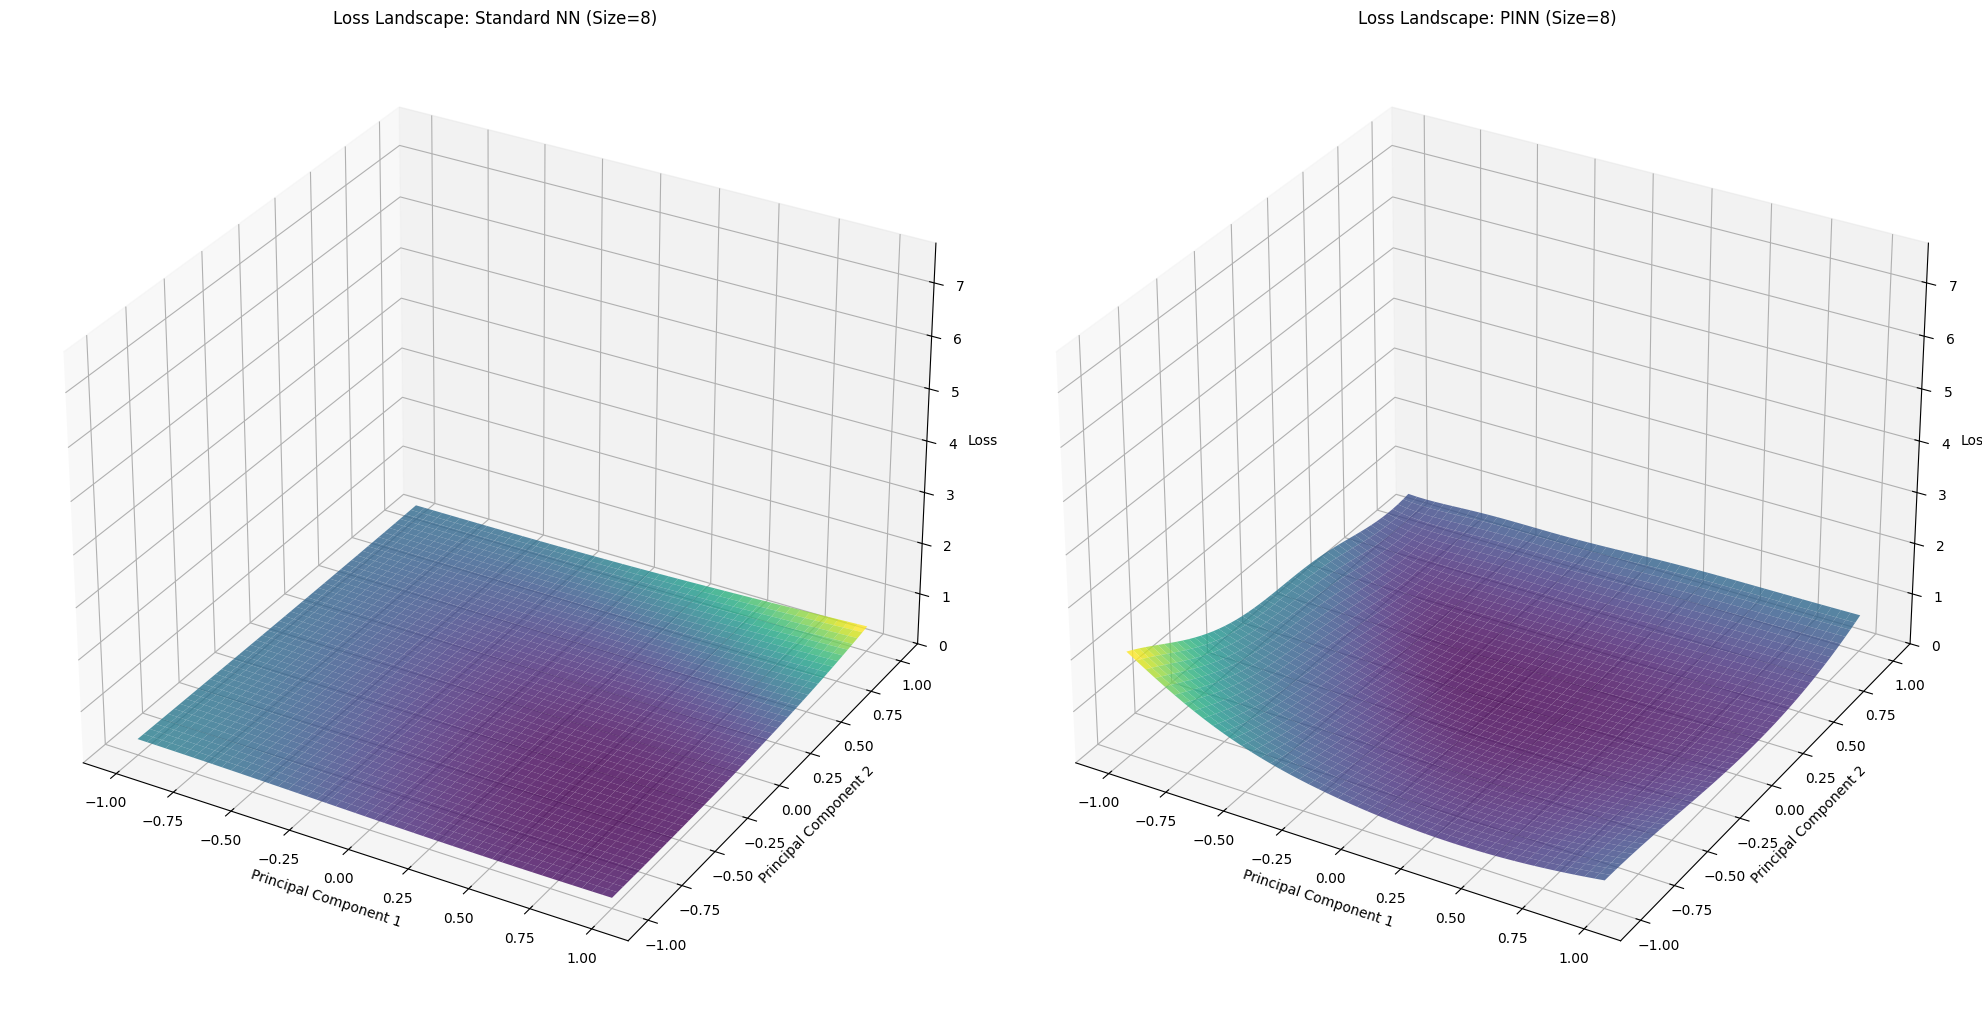

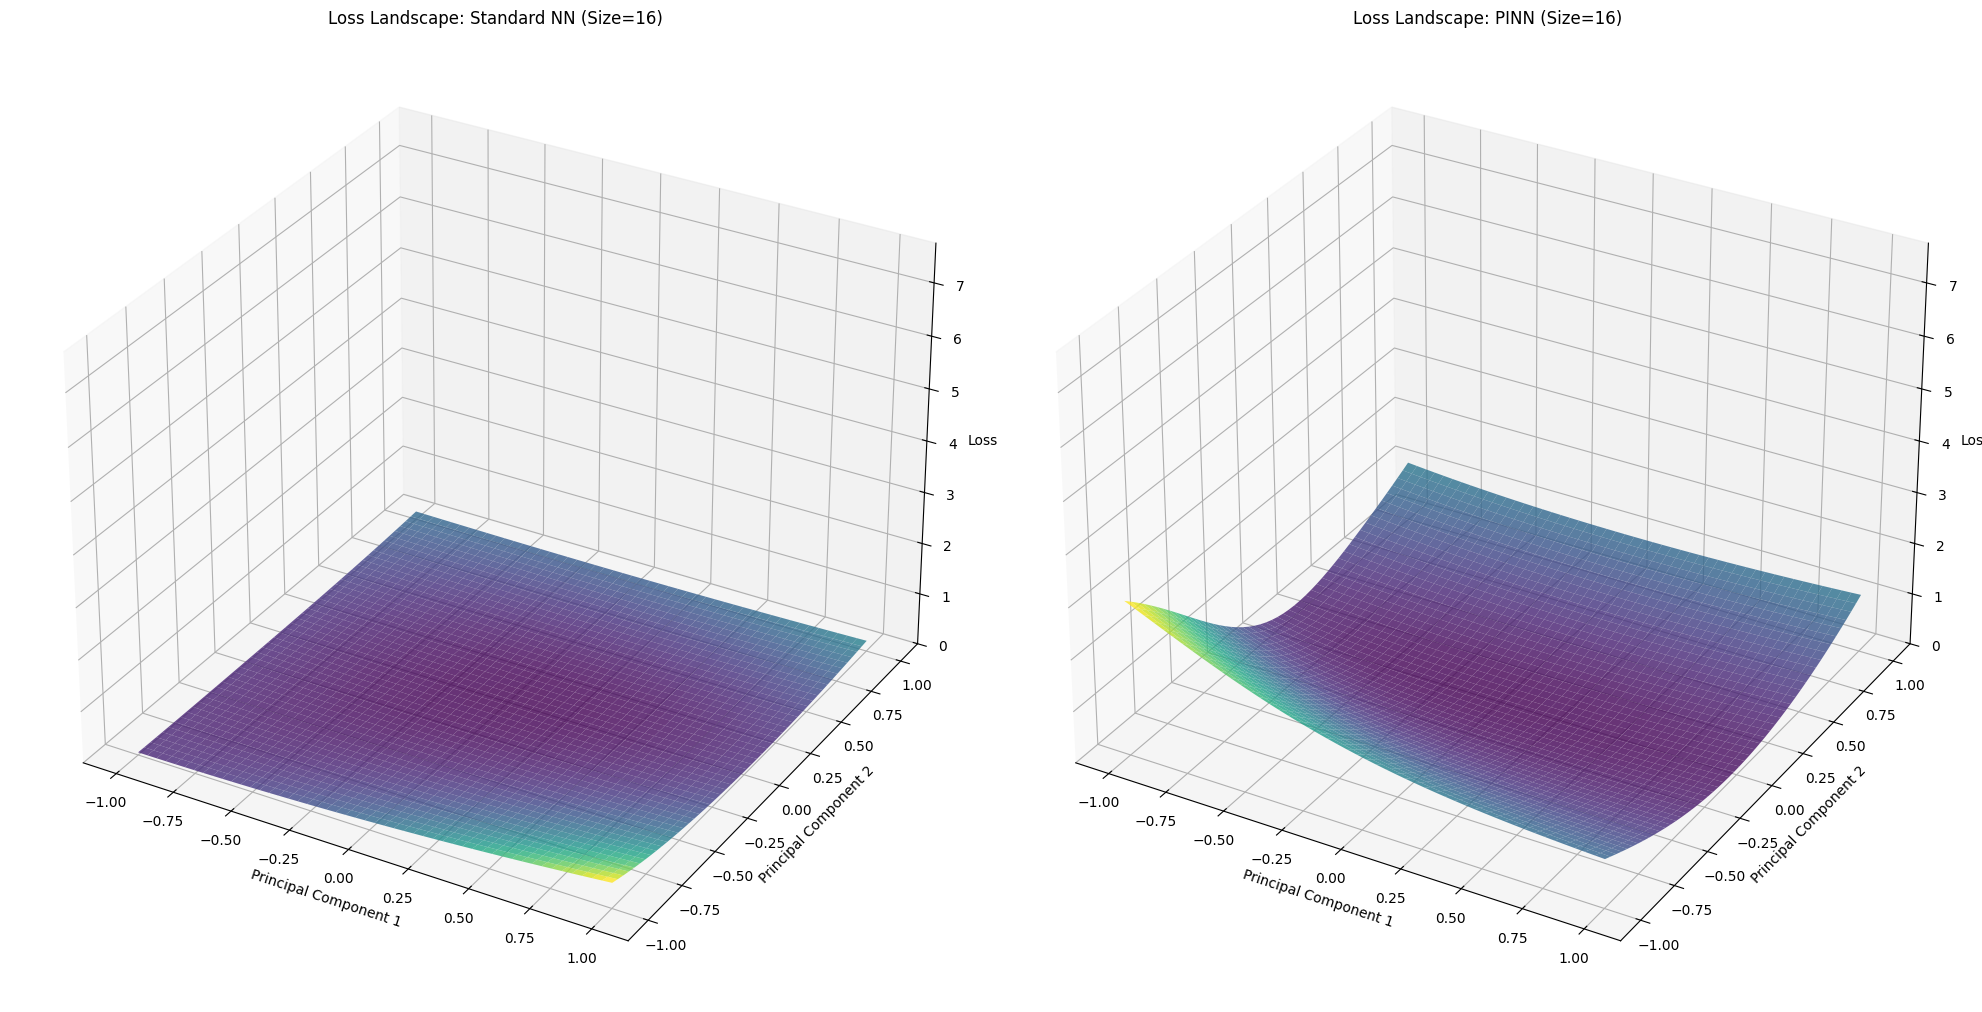

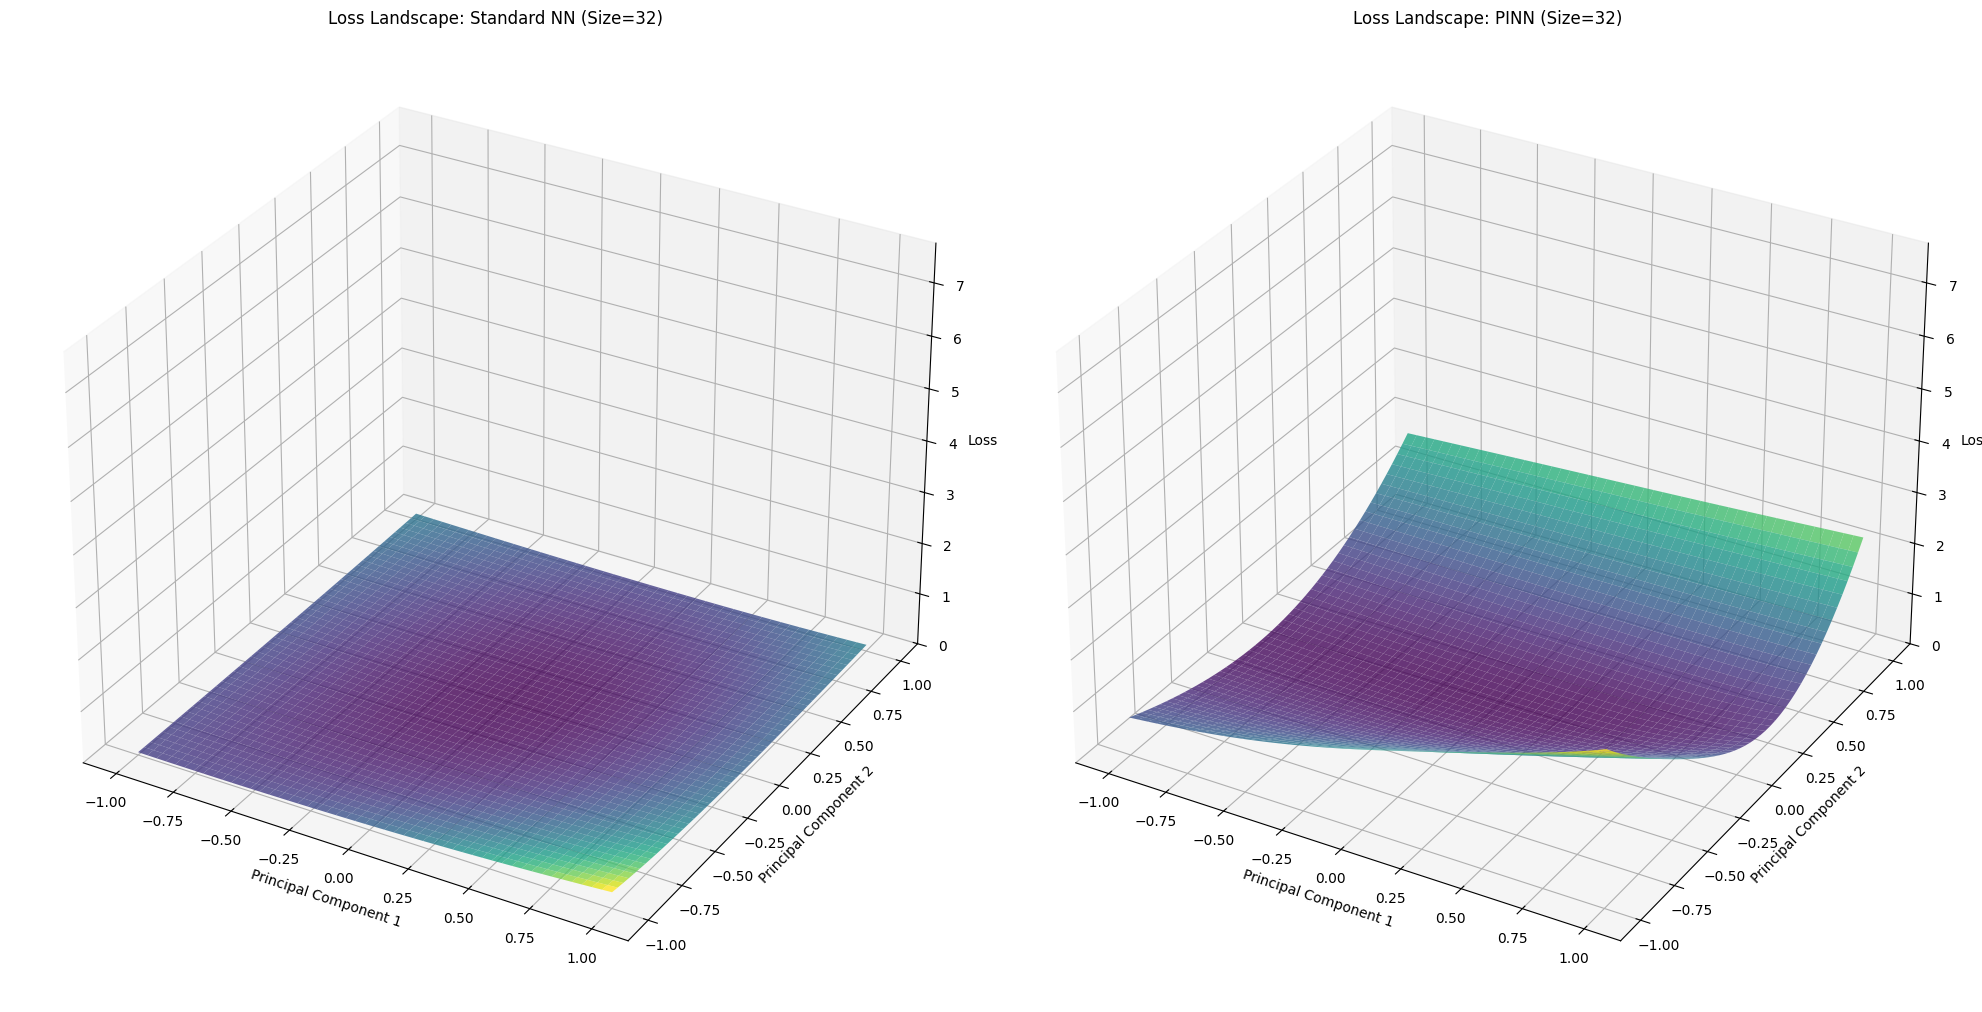

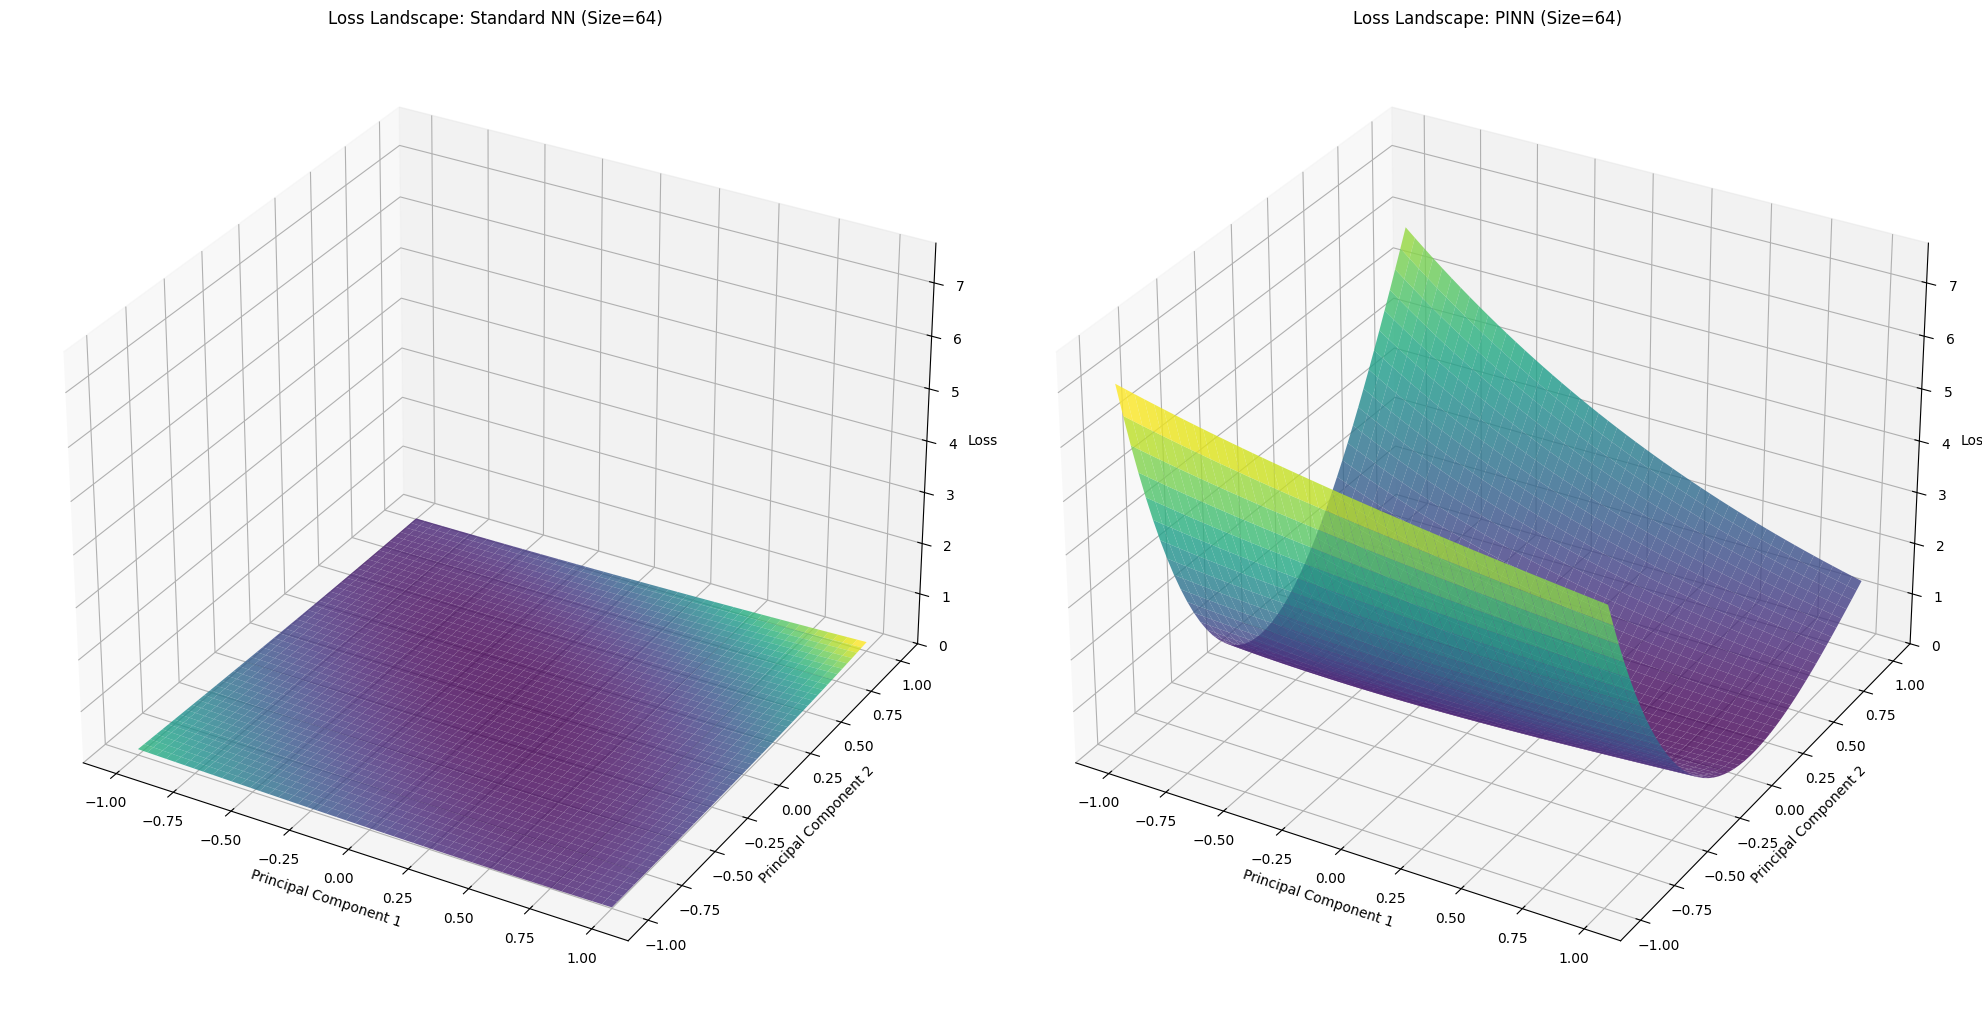

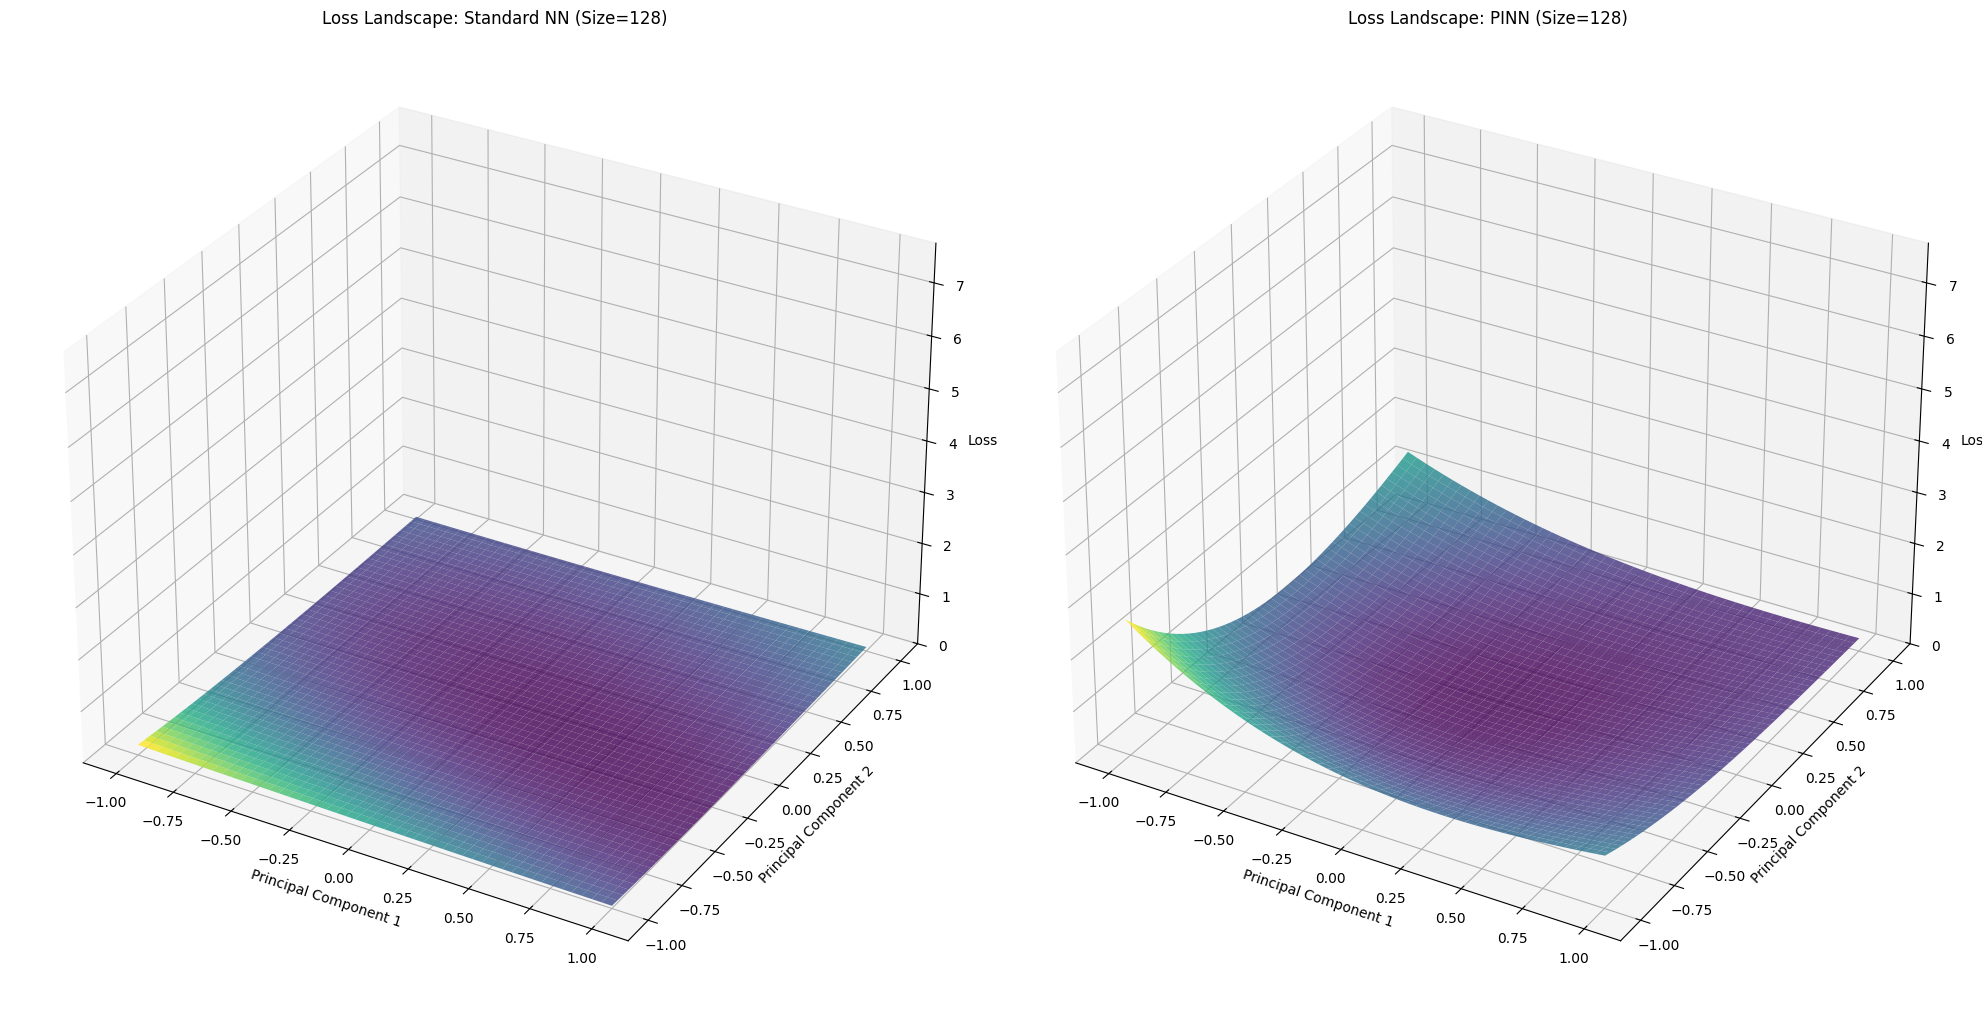

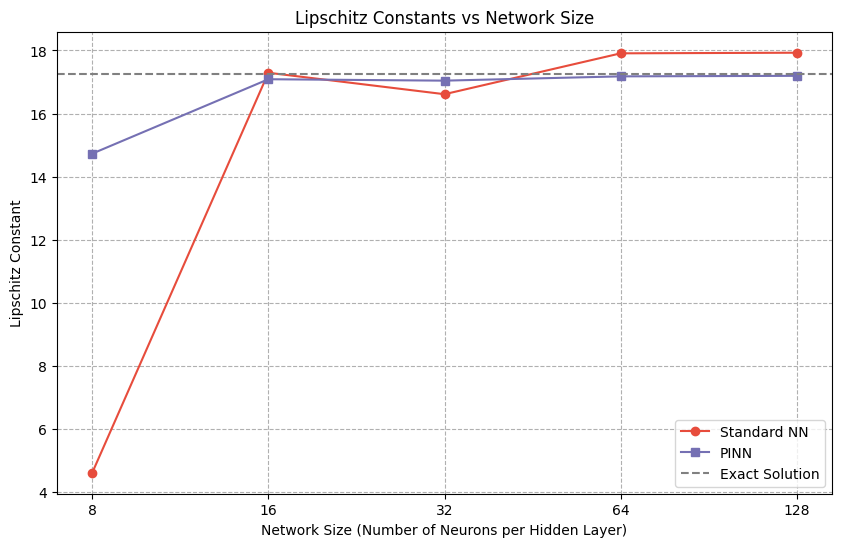

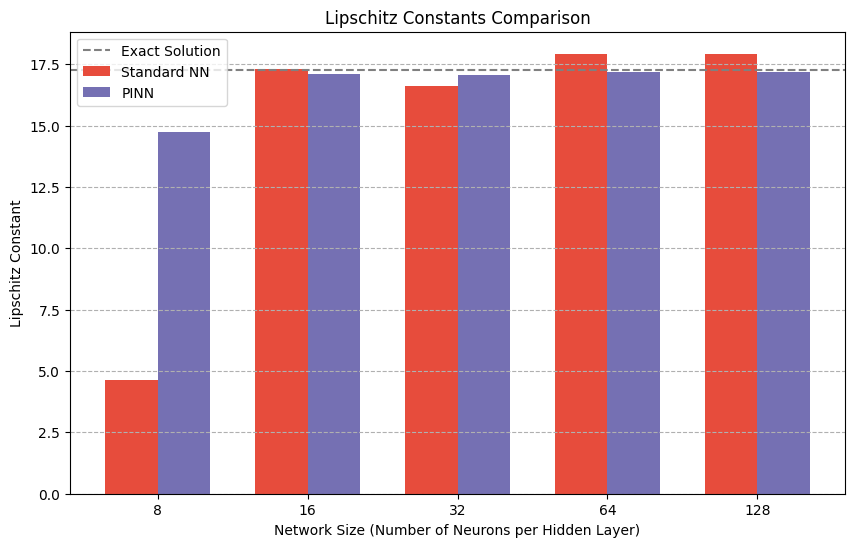

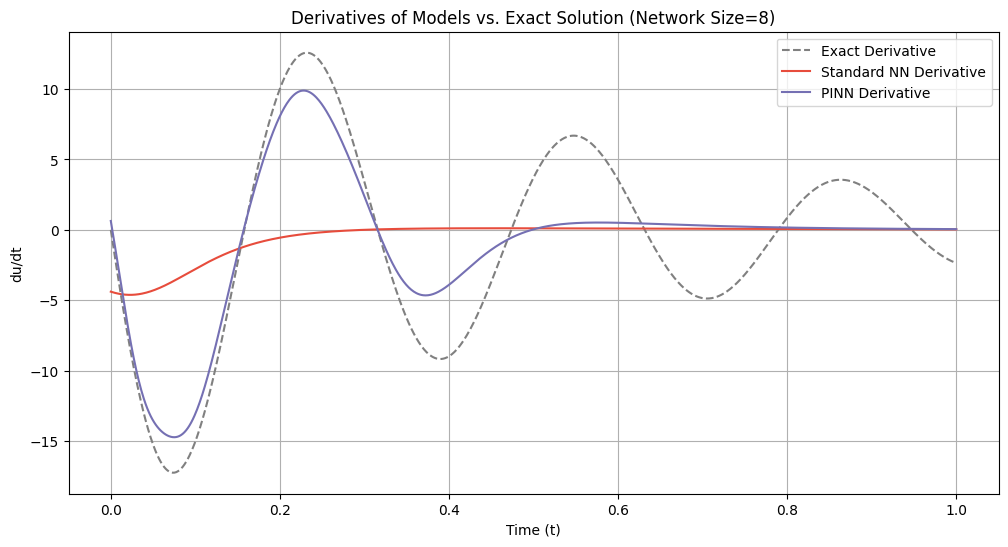

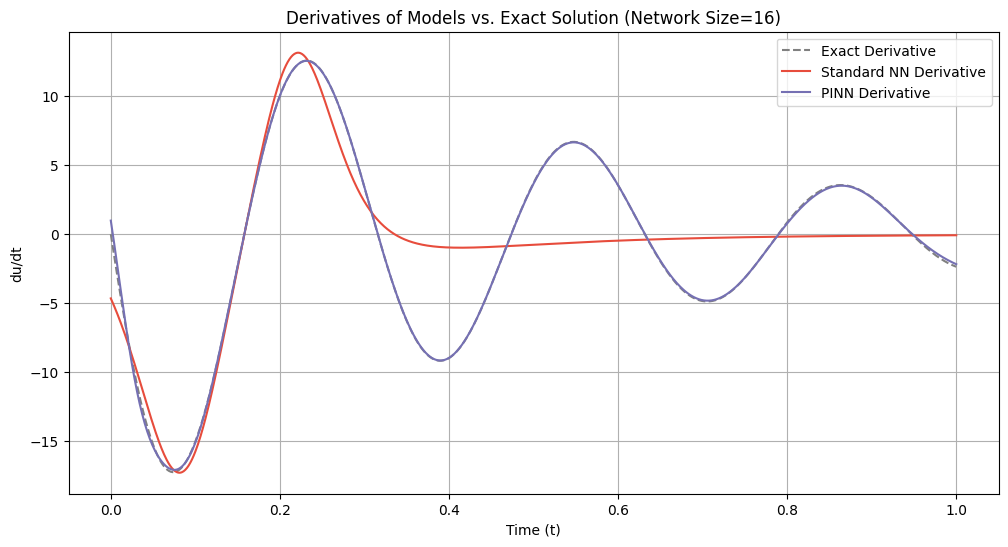

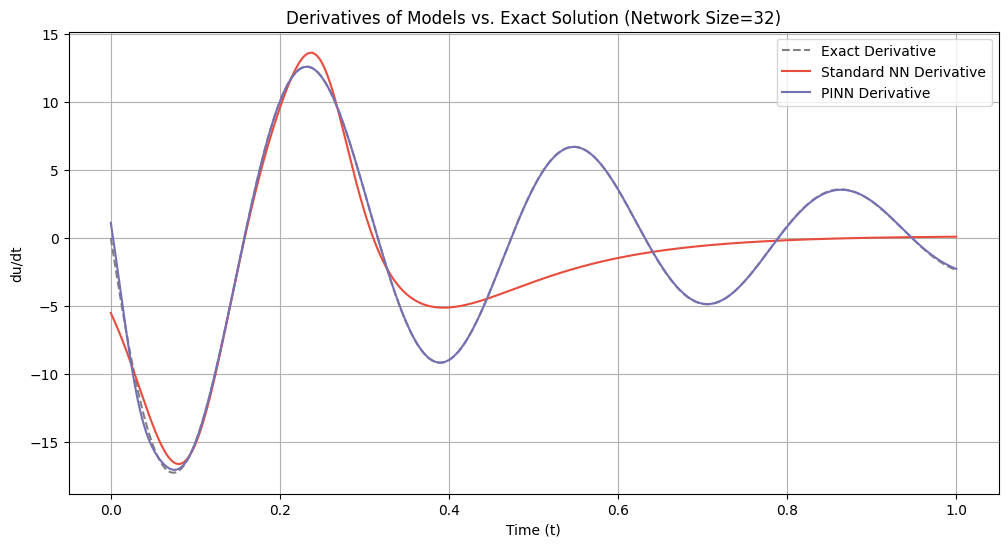

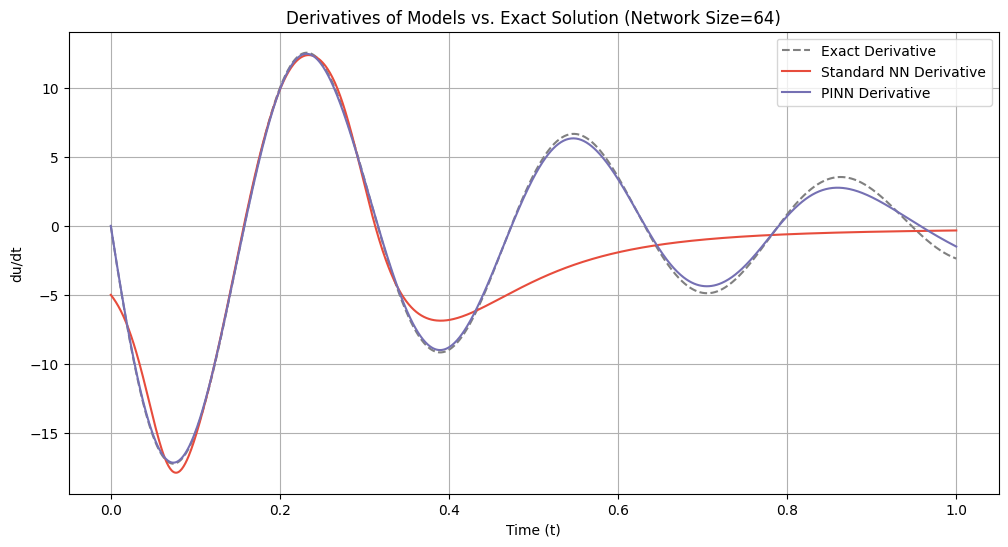

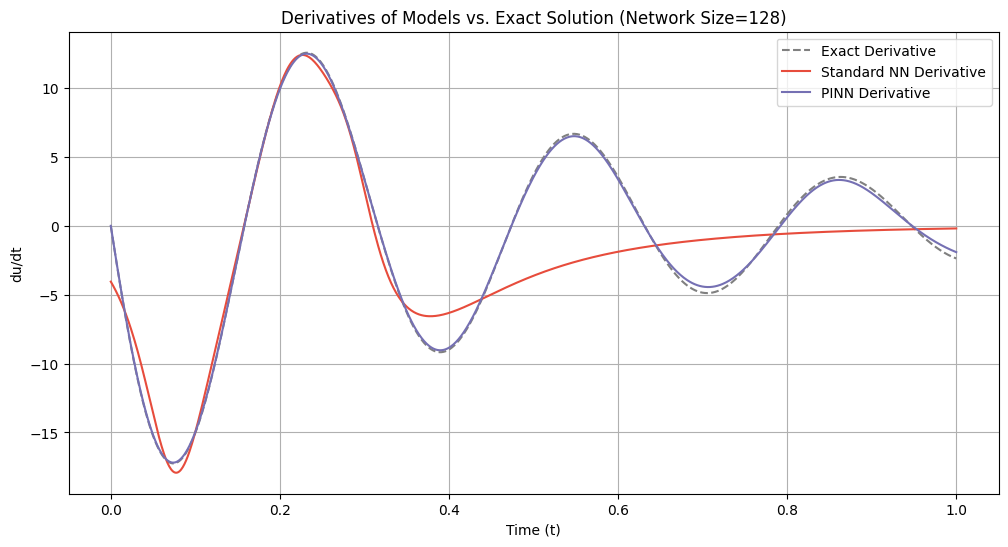

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import base64
from IPython.display import HTML, display
import imageio
from tqdm import tqdm
from sklearn.decomposition import PCA

# Ensure reproducibility
torch.manual_seed(0)
np.random.seed(0)

class HarmonicOscillator:
    def __init__(self, damping_coefficient, natural_frequency):
        self.d = damping_coefficient
        self.w0 = natural_frequency
        assert self.d < self.w0, "Damping coefficient must be less than natural frequency for underdamped oscillator"
        self.w = np.sqrt(self.w0**2 - self.d**2)
        self.phi = np.arctan(-self.d / self.w)
        self.A = 1 / (2 * np.cos(self.phi))
        
    def analytical_solution(self, t):
        """Analytical solution to the 1D underdamped harmonic oscillator problem."""
        cos_part = np.cos(self.phi + self.w * t)
        exp_part = np.exp(-self.d * t)
        u = exp_part * 2 * self.A * cos_part
        return u
    
    def analytical_derivative(self, t):
        """Analytical derivative of the solution."""
        du_dt = -self.d * self.analytical_solution(t) - 2 * self.A * self.w * np.sin(self.phi + self.w * t) * np.exp(-self.d * t)
        return du_dt
    
    def generate_data(self):
        """Generates training data for the oscillator."""
        t = np.linspace(0, 1, 500).reshape(-1, 1)
        u = self.analytical_solution(t).reshape(-1, 1)
        t_data = t[0:200:20]
        u_data = u[0:200:20]
        return t, u, t_data, u_data

class Visualizer:
    def __init__(self):
        # Remove seaborn style to have more control over the plot appearance
        plt.style.use('default')

    def plot_result(self, t, u_exact, t_data, u_data, u_pred, t_physics=None, iteration=None, title=""):
        """
        Plots the results with improved visualization.

        Args:
            t: time array for the full solution
            u_exact: exact displacement solution
            t_data: time array of training data points
            u_data: displacement data of training data points
            u_pred: predicted displacement from the neural network
            t_physics: optional physics points for PINN visualization
            iteration: optional iteration number for animation
            title: optional title for the plot

        Returns:
            image: numpy array containing the plot image
        """
        fig, ax = plt.subplots(figsize=(10, 5))

        # Remove grid but keep the box
        ax.grid(False)
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)

        # Plot exact solution
        ax.plot(t, u_exact, color="gray", linewidth=2, linestyle='--', label="Exact Solution")

        # Plot neural network prediction
        ax.plot(t, u_pred, color="blue", linewidth=2, label="Neural Network Prediction")

        # Plot training data points
        ax.scatter(t_data, u_data, color="red", s=50, label="Training Data")

        # Plot physics points if provided (for PINN)
        if t_physics is not None:
            ax.scatter(t_physics, np.zeros_like(t_physics), color="green", s=50, label="Physics Points", marker="^")

        # Add iteration number if provided
        if iteration is not None:
            ax.set_title(f"Training Step: {iteration+1} {title}")

        ax.legend(frameon=True, facecolor='white', edgecolor='black')
        ax.set_xlabel("Time (t)")
        ax.set_ylabel("Displacement u(t)")
        ax.set_xlim([t.min(), t.max()])
        ax.set_ylim([-1.2, 1.2])

        # Set background color to white
        ax.set_facecolor('white')
        fig.patch.set_facecolor('white')

        # Convert plot to image array
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (4,))
        plt.close(fig)
        return image

    def create_animation(self, frames, filename='animation.gif', fps=5):
        """Creates and saves an animation from frames."""
        imageio.mimsave(filename, frames, fps=fps)

    def display_animation(self, filename='animation.gif'):
        """Displays the animation as HTML."""
        with open(filename, 'rb') as f:
            data = f.read()
        data_url = "data:image/gif;base64," + base64.b64encode(data).decode()
        display(HTML('<img src="{}">'.format(data_url)))

class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        layers = []
        for in_size, out_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layers.append(nn.Linear(in_size, out_size))
            layers.append(nn.Tanh())
        layers.pop()  # Remove the last activation function
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

def pinn_loss(model, t_data, u_data, t_physics, mu, k):
    """Computes the loss for PINN, including data and physics losses."""
    # Data loss
    u_pred = model(t_data)
    loss_data = nn.MSELoss()(u_pred, u_data)

    # Physics loss
    t_physics = t_physics.clone().detach().requires_grad_(True)
    u_physics = model(t_physics)

    du_dt = torch.autograd.grad(u_physics, t_physics, grad_outputs=torch.ones_like(u_physics),
                                create_graph=True)[0]
    d2u_dt2 = torch.autograd.grad(du_dt, t_physics, grad_outputs=torch.ones_like(du_dt),
                                  create_graph=True)[0]

    physics = d2u_dt2 + mu * du_dt + k * u_physics
    loss_physics = 1e-4 * torch.mean(physics ** 2)

    return loss_data + loss_physics

def train_standard_nn(ho, visualizer, layer_sizes, num_steps=1000, record_interval=100):
    """Trains a standard neural network and collects parameter trajectories."""
    t, u_exact, t_data, u_data = ho.generate_data()

    # Initialize neural network model
    model = NeuralNetwork(layer_sizes)
    model.train()

    # Prepare data
    t_data_tensor = torch.tensor(t_data, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
    t_full_tensor = torch.tensor(t, dtype=torch.float32)

    # Define optimizer and loss function
    learning_rate = 1e-3
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    # Training loop
    frames = []
    losses = []
    param_trajectory = []
    derivative_std_all = []

    for step in tqdm(range(num_steps), desc="Training Standard NN"):
        model.train()
        optimizer.zero_grad()
        u_pred = model(t_data_tensor)
        loss = criterion(u_pred, u_data_tensor)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Store parameter vector
        param_vector = []
        for param in model.parameters():
            param_vector.append(param.data.cpu().numpy().flatten())
        param_vector = np.concatenate(param_vector)
        param_trajectory.append(param_vector)

        # Record frames for animation
        if (step + 1) % record_interval == 0:
            model.eval()
            with torch.no_grad():
                u_pred_full = model(t_full_tensor).numpy()
            image = visualizer.plot_result(t, u_exact, t_data, u_data, u_pred_full, iteration=step, title="[Standard NN]")
            frames.append(image)

    # Create and display animation
    visualizer.create_animation(frames, filename='oscillator_nn.gif', fps=2)
    visualizer.display_animation('oscillator_nn.gif')

    return model, losses, np.array(param_trajectory)

def train_pinn(ho, visualizer, layer_sizes, num_steps=20000, record_interval=1500):
    """Trains a physics-informed neural network and collects parameter trajectories."""
    t, u_exact, t_data, u_data = ho.generate_data()

    # Physics points for PINN
    t_physics = np.linspace(0, 1, 30).reshape(-1, 1)
    mu = 2 * ho.d
    k_param = ho.w0**2

    # Initialize neural network model
    model = NeuralNetwork(layer_sizes)
    model.train()

    # Prepare data
    t_data_tensor = torch.tensor(t_data, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
    t_full_tensor = torch.tensor(t, dtype=torch.float32)
    t_physics_tensor = torch.tensor(t_physics, dtype=torch.float32)
    mu_tensor = torch.tensor(mu, dtype=torch.float32)
    k_param_tensor = torch.tensor(k_param, dtype=torch.float32)

    # Define optimizer
    learning_rate = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    frames = []
    losses = []
    param_trajectory = []
    derivative_pinn_all = []

    for step in tqdm(range(num_steps), desc="Training PINN"):
        model.train()
        optimizer.zero_grad()

        loss = pinn_loss(model, t_data_tensor, u_data_tensor, t_physics_tensor, mu_tensor, k_param_tensor)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # Store parameter vector
        param_vector = []
        for param in model.parameters():
            param_vector.append(param.data.cpu().numpy().flatten())
        param_vector = np.concatenate(param_vector)
        param_trajectory.append(param_vector)

        # Record frames for animation
        if (step + 1) % record_interval == 0:
            model.eval()
            with torch.no_grad():
                u_pred_full = model(t_full_tensor).numpy()
            image = visualizer.plot_result(t, u_exact, t_data, u_data, u_pred_full,
                                           t_physics=t_physics, iteration=step, title="[PINN]")
            frames.append(image)

    # Create and display animation
    visualizer.create_animation(frames, filename='oscillator_pinn.gif', fps=2)
    visualizer.display_animation('oscillator_pinn.gif')

    return model, losses, np.array(param_trajectory)

def evaluate_lipschitz_constant(model, t_samples):
    """
    Evaluates the Lipschitz constant of the model over the sampled t values.

    Args:
        model: Trained neural network model
        t_samples: Numpy array of t values

    Returns:
        lipschitz_constant: Estimated Lipschitz constant
        du_dt: Array of derivative values
    """
    model.eval()  # Set model to evaluation mode

    # Enable gradient tracking
    t_tensor = torch.tensor(t_samples, dtype=torch.float32, requires_grad=True).reshape(-1,1)
    u_pred = model(t_tensor)

    # Compute derivatives
    du_dt = torch.autograd.grad(u_pred, t_tensor, grad_outputs=torch.ones_like(u_pred),
                                create_graph=False)[0]

    du_dt_np = du_dt.detach().numpy().flatten()
    lipschitz_constant = np.max(np.abs(du_dt_np))

    return lipschitz_constant, du_dt_np

def perform_pca(param_trajectory, n_components=2):
    """
    Performs PCA on the parameter trajectory to find principal directions.

    Args:
        param_trajectory: Array of parameter vectors (num_steps x num_params)
        n_components: Number of principal components to return

    Returns:
        components: Principal components (n_components x num_params)
        pca_model: Fitted PCA model
    """
    pca = PCA(n_components=n_components)
    pca.fit(param_trajectory)
    components = pca.components_
    return components, pca

def evaluate_loss_landscape_pca(model, model_type, loss_function, pca_components, param_step=0.1, param_range=1.0):
    """
    Evaluates the loss landscape around the current model parameters using PCA components.

    Args:
        model: Trained neural network model
        model_type: 'standard' or 'pinn'
        loss_function: Function to compute the loss
        pca_components: Tuple of two principal components (numpy arrays)
        param_step: Step size for parameter perturbation
        param_range: Range for parameter perturbation

    Returns:
        X, Y, Z: Meshgrid arrays and corresponding loss values
    """
    # Extract current model parameters as a single vector
    original_params = []
    for param in model.parameters():
        original_params.append(param.data.cpu().numpy().flatten())
    original_params = np.concatenate(original_params)

    # Directions
    d1, d2 = pca_components

    # Create a grid
    alpha = np.linspace(-param_range, param_range, 50)
    beta = np.linspace(-param_range, param_range, 50)
    X, Y = np.meshgrid(alpha, beta)
    Z = np.zeros_like(X)

    # Iterate over the grid and compute loss
    for i in tqdm(range(X.shape[0]), desc=f"Evaluating Loss Landscape [{model_type}]"):
        for j in range(X.shape[1]):
            # Perturb parameters
            perturbed_params = original_params + X[i, j] * d1 + Y[i, j] * d2

            # Load perturbed parameters into the model
            current_idx = 0
            for param in model.parameters():
                param_shape = param.data.cpu().numpy().shape
                param_size = param.data.numel()
                new_values = perturbed_params[current_idx:current_idx + param_size]
                new_values = new_values.reshape(param_shape)
                param.data = torch.tensor(new_values, dtype=torch.float32)
                current_idx += param_size

            # Compute loss
            loss = loss_function(model).item()
            Z[i, j] = loss

    # Restore original parameters
    current_idx = 0
    for param in model.parameters():
        param_shape = param.data.cpu().numpy().shape
        param_size = param.data.numel()
        original_values = original_params[current_idx:current_idx + param_size]
        original_values = original_values.reshape(param_shape)
        param.data = torch.tensor(original_values, dtype=torch.float32)
        current_idx += param_size

    return X, Y, Z

def standard_loss(model, ho):
    """Loss function for standard NN: MSE on data."""
    t, u_exact, t_data, u_data = ho.generate_data()
    t_data_tensor = torch.tensor(t_data, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
    u_pred = model(t_data_tensor)
    return nn.MSELoss()(u_pred, u_data_tensor)

def pinn_total_loss(model, ho):
    """Total loss function for PINN: data + physics."""
    t, u_exact, t_data, u_data = ho.generate_data()
    t_physics = np.linspace(0, 1, 30).reshape(-1, 1)
    mu = 2 * ho.d
    k_param = ho.w0**2

    # Prepare tensors
    t_data_tensor = torch.tensor(t_data, dtype=torch.float32)
    u_data_tensor = torch.tensor(u_data, dtype=torch.float32)
    t_physics_tensor = torch.tensor(t_physics, dtype=torch.float32)
    mu_tensor = torch.tensor(mu, dtype=torch.float32)
    k_param_tensor = torch.tensor(k_param, dtype=torch.float32)

    return pinn_loss(model, t_data_tensor, u_data_tensor, t_physics_tensor, mu_tensor, k_param_tensor)

def main():
    # Initialize harmonic oscillator with underdamped parameters
    ho = HarmonicOscillator(damping_coefficient=2, natural_frequency=20)

    # Initialize visualizer
    visualizer = Visualizer()

    # Define network sizes to evaluate
    network_sizes = [8, 16, 32, 64, 128]

    # Initialize lists to store Lipschitz constants
    lipschitz_standard = []
    lipschitz_pinn = []

    # To determine consistent z-axis limits for loss landscapes
    all_loss_values = []

    # Initialize lists to store derivatives
    derivatives_standard = []
    derivatives_pinn = []

    # Compute the exact Lipschitz constant
    t_samples_exact = np.linspace(0, 1, 1000)
    du_dt_exact = ho.analytical_derivative(t_samples_exact)
    lip_exact = np.max(np.abs(du_dt_exact))
    print(f"Exact Solution Lipschitz Constant: {lip_exact:.4f}")

    for size in network_sizes:
        print(f"\n=== Network Size: {size} ===")

        # Define layer sizes based on current network size
        layer_sizes = [1] + [size]*3 + [1]

        # Train Standard NN
        print("\n--- Training Standard Neural Network ---")
        standard_model, standard_losses, standard_params = train_standard_nn(ho, visualizer, layer_sizes)

        # Train PINN
        print("\n--- Training Physics-Informed Neural Network (PINN) ---")
        pinn_model, pinn_losses, pinn_params = train_pinn(ho, visualizer, layer_sizes)

        # Perform PCA on parameter trajectories
        print("\n--- Performing PCA on Parameter Trajectories ---")
        print("Standard NN:")
        standard_components, standard_pca = perform_pca(standard_params)
        print("PINN:")
        pinn_components, pinn_pca = perform_pca(pinn_params)

        # Define loss functions with access to harmonic oscillator
        def standard_loss_fn(model):
            return standard_loss(model, ho)

        def pinn_loss_fn(model):
            return pinn_total_loss(model, ho)

        # Evaluate loss landscapes
        print("\n--- Evaluating Loss Landscape for Standard NN ---")
        X_std, Y_std, Z_std = evaluate_loss_landscape_pca(
            standard_model,
            model_type='Standard NN',
            loss_function=standard_loss_fn,
            pca_components=standard_components,
            param_step=0.1,
            param_range=1.0
        )

        print("\n--- Evaluating Loss Landscape for PINN ---")
        X_pinn, Y_pinn, Z_pinn = evaluate_loss_landscape_pca(
            pinn_model,
            model_type='PINN',
            loss_function=pinn_loss_fn,
            pca_components=pinn_components,
            param_step=0.1,
            param_range=1.0
        )

        # Collect all loss values to determine global z-axis limit
        all_loss_values.extend([Z_std.max(), Z_pinn.max()])

        # Store loss landscapes for plotting later
        if 'loss_landscapes_std' not in locals():
            loss_landscapes_std = []
            loss_landscapes_pinn = []
        loss_landscapes_std.append((X_std, Y_std, Z_std))
        loss_landscapes_pinn.append((X_pinn, Y_pinn, Z_pinn))

        # Evaluate Lipschitz Constants
        print("\n--- Evaluating Lipschitz Constants ---")
        # Define a dense set of t samples
        t_samples = np.linspace(0, 1, 1000)

        # Standard NN
        lip_std, du_dt_std = evaluate_lipschitz_constant(standard_model, t_samples)
        print(f"Standard NN Lipschitz Constant: {lip_std:.4f}")
        lipschitz_standard.append(lip_std)
        derivatives_standard.append(du_dt_std)

        # PINN
        lip_pinn, du_dt_pinn = evaluate_lipschitz_constant(pinn_model, t_samples)
        print(f"PINN Lipschitz Constant: {lip_pinn:.4f}")
        lipschitz_pinn.append(lip_pinn)
        derivatives_pinn.append(du_dt_pinn)

    # Determine global z-axis limit for loss landscapes
    max_loss = max(all_loss_values) * 1.1  # Add 10% buffer

    # Plot loss landscapes for all network sizes with the same z-axis scale
    for idx, size in enumerate(network_sizes):
        X_std, Y_std, Z_std = loss_landscapes_std[idx]
        X_pinn, Y_pinn, Z_pinn = loss_landscapes_pinn[idx]

        fig = plt.figure(figsize=(20, 10))

        # Standard NN Loss Landscape
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot_surface(X_std, Y_std, Z_std, cmap='viridis', alpha=0.8)
        ax1.set_title(f'Loss Landscape: Standard NN (Size={size})')
        ax1.set_xlabel('Principal Component 1')
        ax1.set_ylabel('Principal Component 2')
        ax1.set_zlabel('Loss')
        ax1.set_zlim(0, max_loss)

        # PINN Loss Landscape
        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot_surface(X_pinn, Y_pinn, Z_pinn, cmap='viridis', alpha=0.8)
        ax2.set_title(f'Loss Landscape: PINN (Size={size})')
        ax2.set_xlabel('Principal Component 1')
        ax2.set_ylabel('Principal Component 2')
        ax2.set_zlabel('Loss')
        ax2.set_zlim(0, max_loss)

        plt.tight_layout()
        plt.show()

    # Plot Lipschitz Constants vs Network Size
    plt.figure(figsize=(10, 6))
    plt.plot(network_sizes, lipschitz_standard, marker='o', label='Standard NN', color='#E74C3C')  # E74C3C
    plt.plot(network_sizes, lipschitz_pinn, marker='s', label='PINN', color='#7570b3')           # #7570b3
    plt.axhline(y=lip_exact, color='gray', linestyle='--', label='Exact Solution')
    plt.title('Lipschitz Constants vs Network Size')
    plt.xlabel('Network Size (Number of Neurons per Hidden Layer)')
    plt.ylabel('Lipschitz Constant')
    plt.xscale('log', base=2)  # Corrected keyword argument
    plt.xticks(network_sizes, network_sizes)
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()

    # Additionally, plot the Lipschitz constants as a bar chart
    plt.figure(figsize=(10, 6))
    bar_width = 0.35
    indices = np.arange(len(network_sizes))
    plt.bar(indices - bar_width/2, lipschitz_standard, bar_width, label='Standard NN', color='#E74C3C')  # E74C3C
    plt.bar(indices + bar_width/2, lipschitz_pinn, bar_width, label='PINN', color='#7570b3')           # #7570b3
    # Plot exact Lipschitz constant as a horizontal line
    plt.axhline(y=lip_exact, color='gray', linestyle='--', label='Exact Solution')
    plt.title('Lipschitz Constants Comparison')
    plt.xlabel('Network Size (Number of Neurons per Hidden Layer)')
    plt.ylabel('Lipschitz Constant')
    plt.xticks(indices, network_sizes)
    plt.legend()
    plt.grid(axis='y', linestyle='--')
    plt.show()

    # Plot derivatives for each network size
    for idx, size in enumerate(network_sizes):
        du_dt_std = derivatives_standard[idx]
        du_dt_pinn = derivatives_pinn[idx]

        plt.figure(figsize=(12, 6))
        plt.plot(t_samples_exact, du_dt_exact, label='Exact Derivative', color='gray', linestyle='--')
        plt.plot(t_samples_exact, du_dt_std, label='Standard NN Derivative', color='#E74C3C')
        plt.plot(t_samples_exact, du_dt_pinn, label='PINN Derivative', color='#7570b3')
        plt.title(f'Derivatives of Models vs. Exact Solution (Network Size={size})')
        plt.xlabel('Time (t)')
        plt.ylabel('du/dt')
        plt.legend()
        plt.grid(True)
        plt.show()

if __name__ == '__main__':
    main()
